In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 400 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
#     test_cycle = driver.get_cycle() 
    test_cycle_path = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
    test_cycle = sio.loadmat(test_cycle_path)
    test_cycle = test_cycle["sch_cycle"][:, 1]
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
    print(test_cycle_path)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 5.795
Episode: 1 Exploration P: 1.0000 Total reward: -3652.291804006228 SOC: 1.0000 Cumulative_SOC_deviation: 354.0930 Fuel Consumption: 111.3617


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -5145.678821234541 SOC: 1.0000 Cumulative_SOC_deviation: 499.6054 Fuel Consumption: 149.6245
******************* Test is done *****************


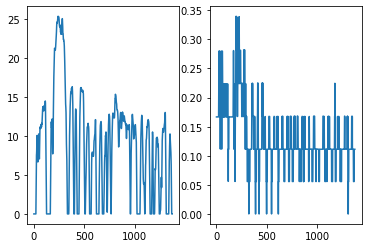

maximum steps, simulation is done ... 
elapsed_time: 6.439
Episode: 2 Exploration P: 1.0000 Total reward: -3642.0623247241933 SOC: 1.0000 Cumulative_SOC_deviation: 354.2051 Fuel Consumption: 100.0118

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -5145.678821234541 SOC: 1.0000 Cumulative_SOC_deviation: 499.6054 Fuel Consumption: 149.6245
******************* Test is done *****************



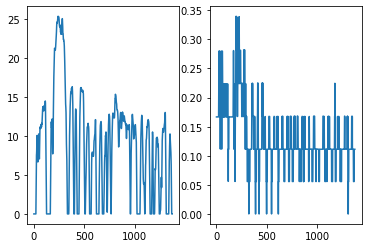

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 6.742
Episode: 3 Exploration P: 1.0000 Total reward: -3654.1466018656934 SOC: 0.9997 Cumulative_SOC_deviation: 354.9089 Fuel Consumption: 105.0573

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -5145.678821234541 SOC: 1.0000 Cumulative_SOC_deviation: 499.6054 Fuel Consumption: 149.6245
******************* Test is done *****************



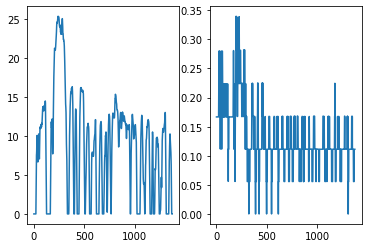

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 6.382
Episode: 4 Exploration P: 1.0000 Total reward: -3640.455588469541 SOC: 1.0000 Cumulative_SOC_deviation: 353.7586 Fuel Consumption: 102.8699

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -5145.678821234541 SOC: 1.0000 Cumulative_SOC_deviation: 499.6054 Fuel Consumption: 149.6245
******************* Test is done *****************



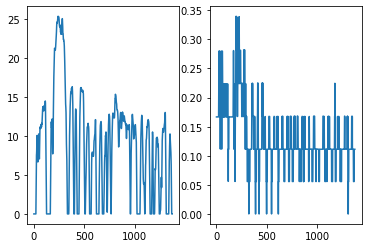


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 6.265
Episode: 5 Exploration P: 0.9999 Total reward: -3647.1653964981633 SOC: 0.9954 Cumulative_SOC_deviation: 354.4584 Fuel Consumption: 102.5810

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -5110.842294980971 SOC: 1.0000 Cumulative_SOC_deviation: 496.5044 Fuel Consumption: 145.7984
******************* Test is done *****************



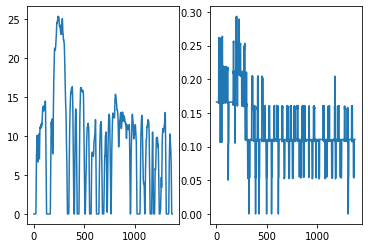

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.697
Episode: 6 Exploration P: 0.9803 Total reward: -3689.1103668563514 SOC: 1.0000 Cumulative_SOC_deviation: 357.4560 Fuel Consumption: 114.5501

battery power is 7582.388027379231(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.9783095443977 SOC: -0.0000 Cumulative_SOC_deviation: 301.9575 Fuel Consumption: 1.4037
******************* Test is done *****************



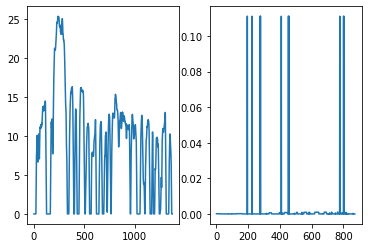

maximum steps, simulation is done ... 
elapsed_time: 44.379
Episode: 7 Exploration P: 0.9611 Total reward: -3643.3732449695835 SOC: 1.0000 Cumulative_SOC_deviation: 354.5745 Fuel Consumption: 97.6283

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4012.8262572589288 SOC: -0.0002 Cumulative_SOC_deviation: 301.7490 Fuel Consumption: 1.3384
******************* Test is done *****************



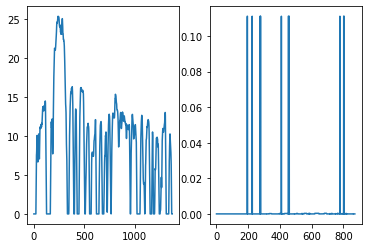

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.276
Episode: 8 Exploration P: 0.9422 Total reward: -3589.7687813031016 SOC: 1.0000 Cumulative_SOC_deviation: 348.8684 Fuel Consumption: 101.0849

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4013.7841115060423 SOC: -0.0005 Cumulative_SOC_deviation: 301.8468 Fuel Consumption: 1.3216
******************* Test is done *****************



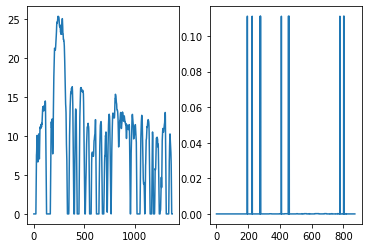

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 103397.50568540553(+) but condition is not avail
elapsed_time: 7.290
Episode: 9 Exploration P: 0.9391 Total reward: -1274.022361863985 SOC: 0.8493 Cumulative_SOC_deviation: 24.5343 Fuel Consumption: 31.3582

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4013.92063626012 SOC: -0.0006 Cumulative_SOC_deviation: 301.8607 Fuel Consumption: 1.3191
******************* Test is done *****************



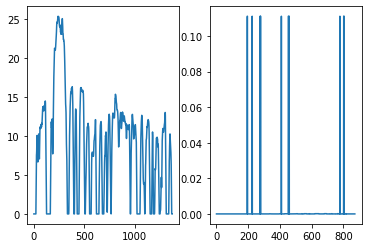

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.693
Episode: 10 Exploration P: 0.9207 Total reward: -3619.242580733791 SOC: 1.0000 Cumulative_SOC_deviation: 352.4080 Fuel Consumption: 95.1622

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.165339433518 SOC: -0.0007 Cumulative_SOC_deviation: 301.8858 Fuel Consumption: 1.3144
******************* Test is done *****************



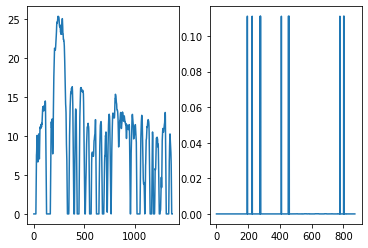

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.240
Episode: 11 Exploration P: 0.9026 Total reward: -3572.445685613829 SOC: 1.0000 Cumulative_SOC_deviation: 347.4683 Fuel Consumption: 97.7624

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.0116937852436 SOC: -0.0006 Cumulative_SOC_deviation: 301.8701 Fuel Consumption: 1.3174
******************* Test is done *****************



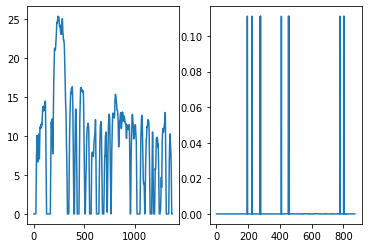

maximum steps, simulation is done ... 
elapsed_time: 42.986
Episode: 12 Exploration P: 0.8849 Total reward: -3603.8780185604046 SOC: 1.0000 Cumulative_SOC_deviation: 351.0944 Fuel Consumption: 92.9335

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.209875162472 SOC: -0.0007 Cumulative_SOC_deviation: 301.8903 Fuel Consumption: 1.3136
******************* Test is done *****************



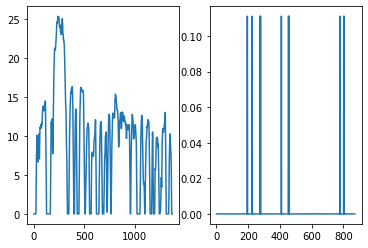

maximum steps, simulation is done ... 
elapsed_time: 42.894
Episode: 13 Exploration P: 0.8676 Total reward: -3582.4912563870575 SOC: 1.0000 Cumulative_SOC_deviation: 349.3716 Fuel Consumption: 88.7753

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.4291627221596 SOC: -0.0008 Cumulative_SOC_deviation: 301.9128 Fuel Consumption: 1.3093
******************* Test is done *****************



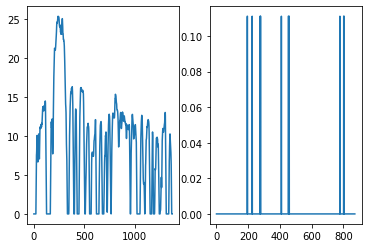

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.096
Episode: 14 Exploration P: 0.8506 Total reward: -3541.1044145111796 SOC: 1.0000 Cumulative_SOC_deviation: 344.3858 Fuel Consumption: 97.2465

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.449375473297 SOC: -0.0008 Cumulative_SOC_deviation: 301.9148 Fuel Consumption: 1.3089
******************* Test is done *****************



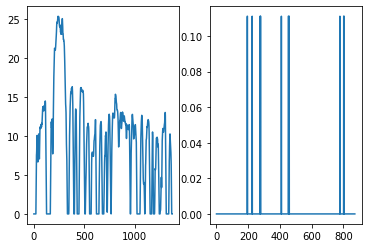

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 42.935
Episode: 15 Exploration P: 0.8339 Total reward: -3550.118591948494 SOC: 1.0000 Cumulative_SOC_deviation: 345.4987 Fuel Consumption: 95.1313

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.5154968339116 SOC: -0.0008 Cumulative_SOC_deviation: 301.9216 Fuel Consumption: 1.3076
******************* Test is done *****************



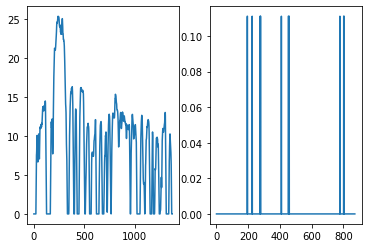

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.199
Episode: 16 Exploration P: 0.8176 Total reward: -3518.8316374625697 SOC: 1.0000 Cumulative_SOC_deviation: 343.2337 Fuel Consumption: 86.4950

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524927724709 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



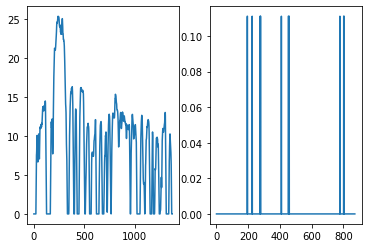

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.854
Episode: 17 Exploration P: 0.8016 Total reward: -3544.176422254895 SOC: 1.0000 Cumulative_SOC_deviation: 345.7496 Fuel Consumption: 86.6807

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



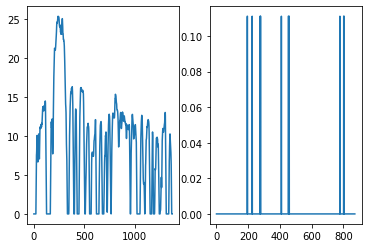

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 42.984
Episode: 18 Exploration P: 0.7859 Total reward: -3481.7130990008227 SOC: 0.9999 Cumulative_SOC_deviation: 339.5053 Fuel Consumption: 86.6601

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



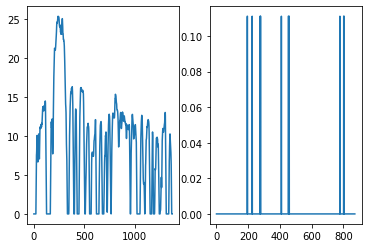

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.566
Episode: 19 Exploration P: 0.7705 Total reward: -3519.0581811295147 SOC: 1.0000 Cumulative_SOC_deviation: 342.7652 Fuel Consumption: 91.4064

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



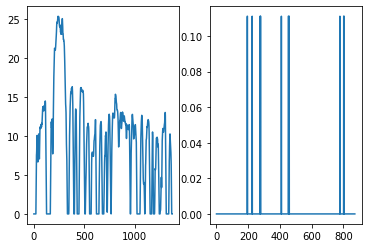

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 51.587
Episode: 20 Exploration P: 0.7554 Total reward: -3418.7703089019737 SOC: 1.0000 Cumulative_SOC_deviation: 334.0189 Fuel Consumption: 78.5810

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



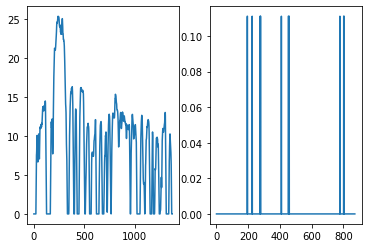

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 51.832
Episode: 21 Exploration P: 0.7407 Total reward: -3414.774302551719 SOC: 0.9955 Cumulative_SOC_deviation: 333.2190 Fuel Consumption: 82.5844

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



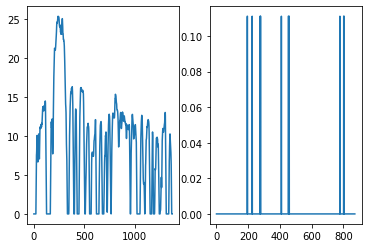

maximum steps, simulation is done ... 
elapsed_time: 51.367
Episode: 22 Exploration P: 0.7262 Total reward: -3457.4923803919555 SOC: 1.0000 Cumulative_SOC_deviation: 337.9376 Fuel Consumption: 78.1167

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



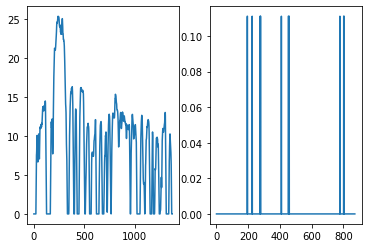

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 51.957
Episode: 23 Exploration P: 0.7120 Total reward: -3529.71332966438 SOC: 1.0000 Cumulative_SOC_deviation: 344.7789 Fuel Consumption: 81.9241

battery power is 6936.508034285002(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4015.2993430169727 SOC: -0.0005 Cumulative_SOC_deviation: 301.9657 Fuel Consumption: 1.6471
******************* Test is done *****************



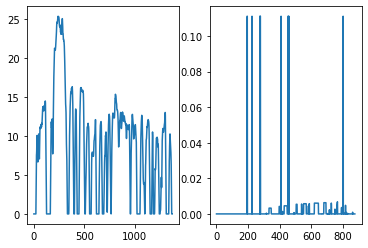

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 52.484
Episode: 24 Exploration P: 0.6981 Total reward: -3347.1071813717795 SOC: 1.0000 Cumulative_SOC_deviation: 326.8364 Fuel Consumption: 78.7430

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -3198.760409273354 SOC: 0.3982 Cumulative_SOC_deviation: 316.2041 Fuel Consumption: 36.7190
******************* Test is done *****************



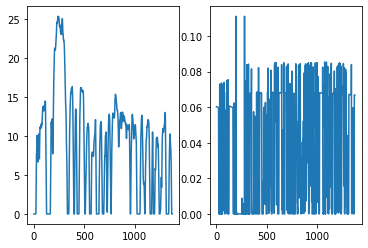

maximum steps, simulation is done ... 
elapsed_time: 52.470
Episode: 25 Exploration P: 0.6844 Total reward: -3391.1899586157456 SOC: 1.0000 Cumulative_SOC_deviation: 331.3812 Fuel Consumption: 77.3778

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -2415.512334752687 SOC: 0.5227 Cumulative_SOC_deviation: 237.1053 Fuel Consumption: 44.4598
******************* Test is done *****************



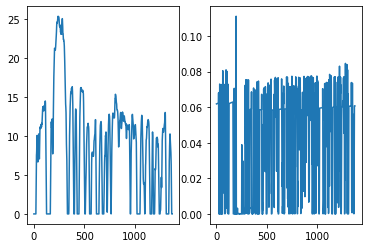

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 52.840
Episode: 26 Exploration P: 0.6711 Total reward: -3392.0915170390067 SOC: 1.0000 Cumulative_SOC_deviation: 331.2048 Fuel Consumption: 80.0439

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -1882.0466881986226 SOC: 0.6008 Cumulative_SOC_deviation: 183.2456 Fuel Consumption: 49.5911
******************* Test is done *****************



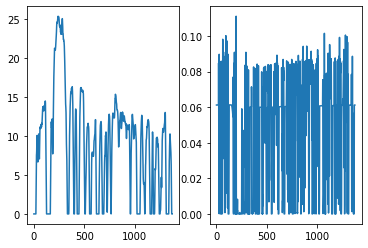

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 52.668
Episode: 27 Exploration P: 0.6580 Total reward: -3308.913275600038 SOC: 1.0000 Cumulative_SOC_deviation: 323.3283 Fuel Consumption: 75.6306

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -3666.087112846784 SOC: 0.3051 Cumulative_SOC_deviation: 363.6461 Fuel Consumption: 29.6263
******************* Test is done *****************



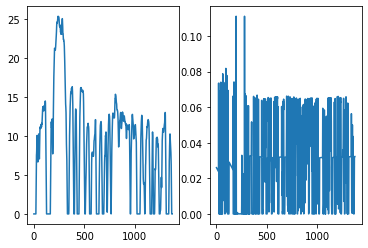

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 53.076
Episode: 28 Exploration P: 0.6451 Total reward: -3314.128828529015 SOC: 1.0000 Cumulative_SOC_deviation: 324.1573 Fuel Consumption: 72.5562

maximum steps, simulation is done ... 
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -2416.138963008968 SOC: 0.4934 Cumulative_SOC_deviation: 237.4448 Fuel Consumption: 41.6913
******************* Test is done *****************



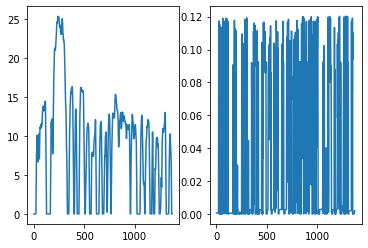

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 52.337
Episode: 29 Exploration P: 0.6325 Total reward: -3376.855606414087 SOC: 1.0000 Cumulative_SOC_deviation: 330.2513 Fuel Consumption: 74.3423

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



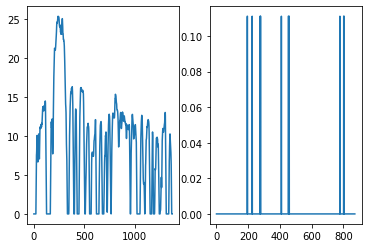

maximum steps, simulation is done ... 
elapsed_time: 52.319
Episode: 30 Exploration P: 0.6202 Total reward: -3380.9995383811415 SOC: 1.0000 Cumulative_SOC_deviation: 331.2200 Fuel Consumption: 68.7994

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



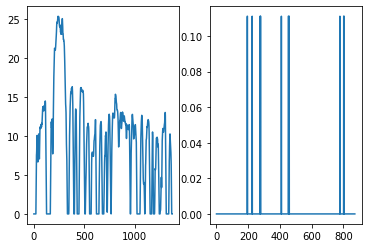

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 50.747
Episode: 31 Exploration P: 0.6081 Total reward: -3139.3393074889345 SOC: 0.9988 Cumulative_SOC_deviation: 307.7628 Fuel Consumption: 61.7108

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



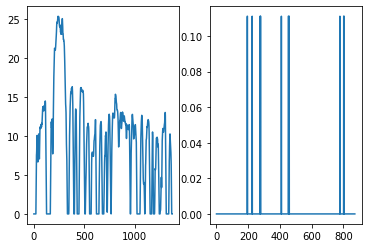

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.948
Episode: 32 Exploration P: 0.5962 Total reward: -3023.833295461053 SOC: 1.0000 Cumulative_SOC_deviation: 293.2303 Fuel Consumption: 91.5303

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



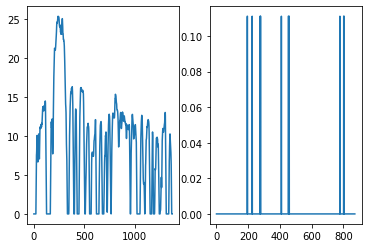

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 50.619
Episode: 33 Exploration P: 0.5846 Total reward: -3294.4546050108484 SOC: 1.0000 Cumulative_SOC_deviation: 323.2393 Fuel Consumption: 62.0617

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



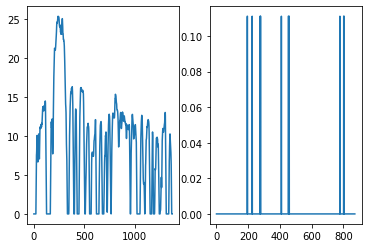

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.800
Episode: 34 Exploration P: 0.5732 Total reward: -2934.419202585499 SOC: 1.0000 Cumulative_SOC_deviation: 284.8646 Fuel Consumption: 85.7727

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



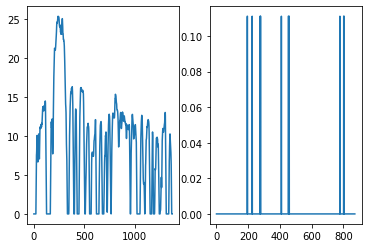

maximum steps, simulation is done ... 
elapsed_time: 47.327
Episode: 35 Exploration P: 0.5621 Total reward: -3235.1713499610114 SOC: 1.0000 Cumulative_SOC_deviation: 316.6496 Fuel Consumption: 68.6756

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



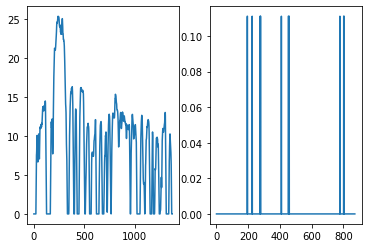

maximum steps, simulation is done ... 
elapsed_time: 46.698
Episode: 36 Exploration P: 0.5511 Total reward: -3130.563572233972 SOC: 0.9999 Cumulative_SOC_deviation: 307.1979 Fuel Consumption: 58.5844

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



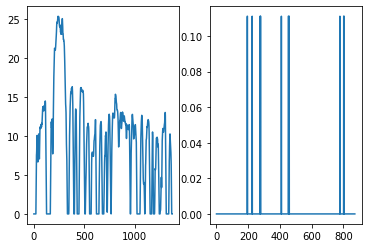

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.828
Episode: 37 Exploration P: 0.5404 Total reward: -2908.293775074232 SOC: 1.0000 Cumulative_SOC_deviation: 284.3591 Fuel Consumption: 64.7031

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



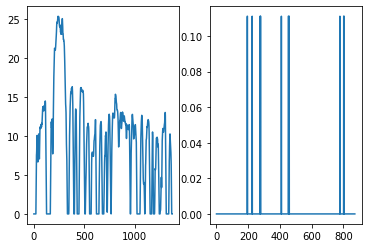

maximum steps, simulation is done ... 
elapsed_time: 43.395
Episode: 38 Exploration P: 0.5299 Total reward: -3147.151884790037 SOC: 0.9999 Cumulative_SOC_deviation: 308.5699 Fuel Consumption: 61.4529

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



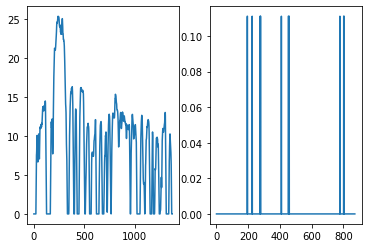

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.094
Episode: 39 Exploration P: 0.5196 Total reward: -3025.122628211425 SOC: 1.0000 Cumulative_SOC_deviation: 295.8067 Fuel Consumption: 67.0556

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



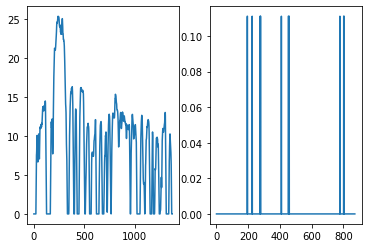

maximum steps, simulation is done ... 
elapsed_time: 43.201
Episode: 40 Exploration P: 0.5095 Total reward: -3079.0829569121515 SOC: 1.0000 Cumulative_SOC_deviation: 302.2345 Fuel Consumption: 56.7375

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



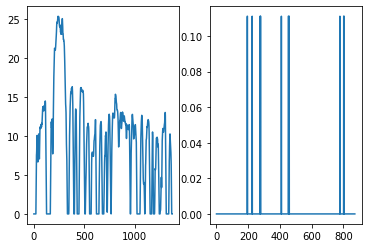

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.079
Episode: 41 Exploration P: 0.4996 Total reward: -3125.274372004339 SOC: 0.9997 Cumulative_SOC_deviation: 306.3388 Fuel Consumption: 61.8862

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



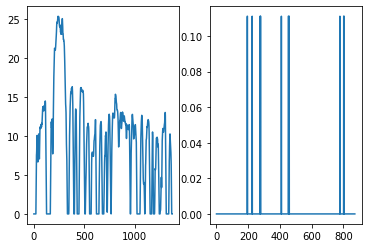

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.138
Episode: 42 Exploration P: 0.4899 Total reward: -3030.8160845044886 SOC: 1.0000 Cumulative_SOC_deviation: 296.6319 Fuel Consumption: 64.4967

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



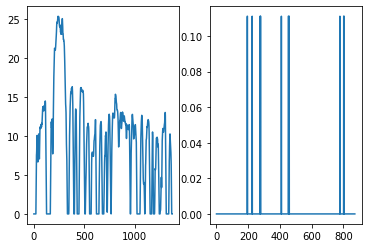

maximum steps, simulation is done ... 
elapsed_time: 44.007
Episode: 43 Exploration P: 0.4804 Total reward: -3011.0517088160586 SOC: 0.9962 Cumulative_SOC_deviation: 295.5460 Fuel Consumption: 55.5922

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



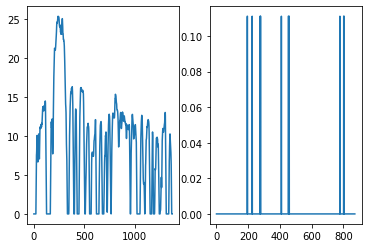

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.744
Episode: 44 Exploration P: 0.4710 Total reward: -2972.909379863491 SOC: 1.0000 Cumulative_SOC_deviation: 291.8659 Fuel Consumption: 54.2508

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



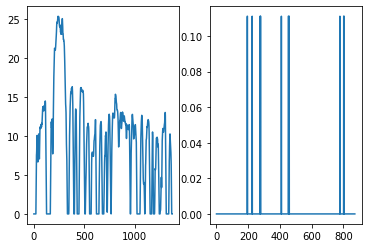

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.087
Episode: 45 Exploration P: 0.4619 Total reward: -2967.824076323689 SOC: 1.0000 Cumulative_SOC_deviation: 290.9436 Fuel Consumption: 58.3884

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



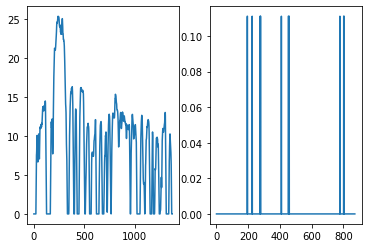

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.243
Episode: 46 Exploration P: 0.4530 Total reward: -2844.712979840779 SOC: 0.9942 Cumulative_SOC_deviation: 279.0122 Fuel Consumption: 54.5913

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



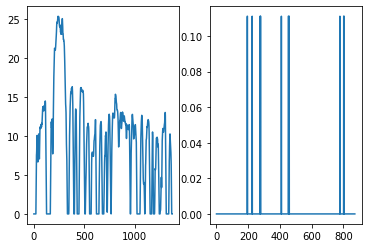

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.174
Episode: 47 Exploration P: 0.4442 Total reward: -2807.980473242174 SOC: 0.9922 Cumulative_SOC_deviation: 275.3864 Fuel Consumption: 54.1167

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



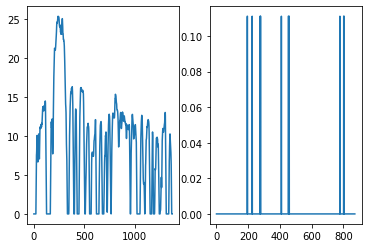

maximum steps, simulation is done ... 
elapsed_time: 43.141
Episode: 48 Exploration P: 0.4356 Total reward: -2934.5445503346623 SOC: 0.9998 Cumulative_SOC_deviation: 288.4327 Fuel Consumption: 50.2173

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4013.582708787959 SOC: -0.0007 Cumulative_SOC_deviation: 301.8278 Fuel Consumption: 1.3117
******************* Test is done *****************



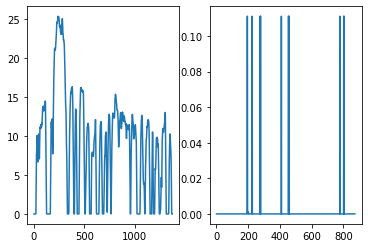

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.569
Episode: 49 Exploration P: 0.4271 Total reward: -2917.402778594667 SOC: 1.0000 Cumulative_SOC_deviation: 286.4734 Fuel Consumption: 52.6683

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.4005200080724 SOC: -0.0008 Cumulative_SOC_deviation: 301.9101 Fuel Consumption: 1.3079
******************* Test is done *****************



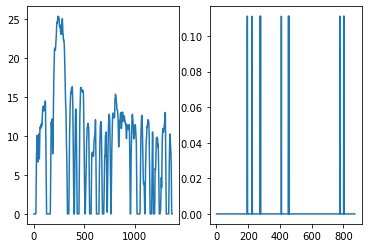

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.095
Episode: 50 Exploration P: 0.4189 Total reward: -2713.704897613735 SOC: 0.9988 Cumulative_SOC_deviation: 266.2860 Fuel Consumption: 50.8446

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



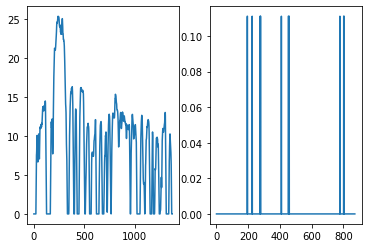

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 44.169
Episode: 51 Exploration P: 0.4108 Total reward: -2773.3571648194297 SOC: 0.9999 Cumulative_SOC_deviation: 271.8774 Fuel Consumption: 54.5834

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.4921211175483 SOC: -0.0008 Cumulative_SOC_deviation: 301.9193 Fuel Consumption: 1.3075
******************* Test is done *****************



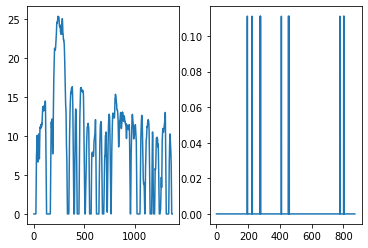

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.576
Episode: 52 Exploration P: 0.4028 Total reward: -2516.1315619297343 SOC: 0.8658 Cumulative_SOC_deviation: 245.2991 Fuel Consumption: 63.1405

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



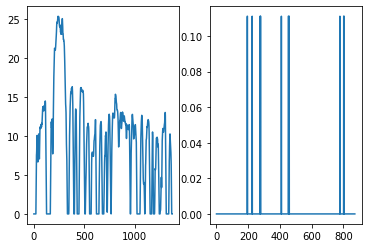

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.985
Episode: 53 Exploration P: 0.3950 Total reward: -2428.8236961396155 SOC: 0.9074 Cumulative_SOC_deviation: 236.8307 Fuel Consumption: 60.5167

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



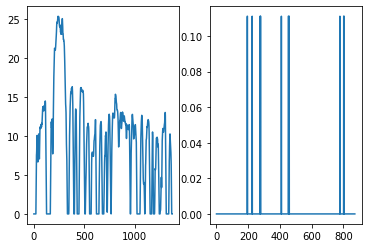

maximum steps, simulation is done ... 
elapsed_time: 43.641
Episode: 54 Exploration P: 0.3874 Total reward: -2500.4855604198488 SOC: 0.9997 Cumulative_SOC_deviation: 245.0021 Fuel Consumption: 50.4645

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



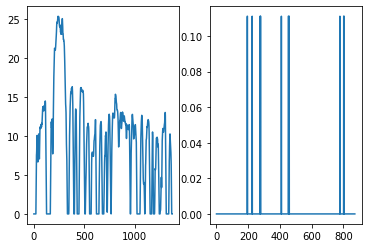

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.257
Episode: 55 Exploration P: 0.3799 Total reward: -1493.8684441175483 SOC: 0.9735 Cumulative_SOC_deviation: 142.8689 Fuel Consumption: 65.1797

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.496877769673 SOC: -0.0008 Cumulative_SOC_deviation: 301.9197 Fuel Consumption: 1.3075
******************* Test is done *****************



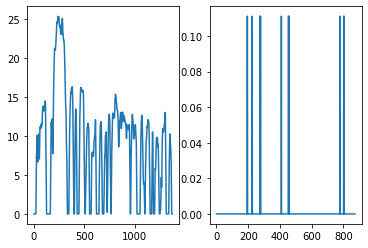

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.147
Episode: 56 Exploration P: 0.3726 Total reward: -2340.5538352791655 SOC: 0.9800 Cumulative_SOC_deviation: 228.6705 Fuel Consumption: 53.8485

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



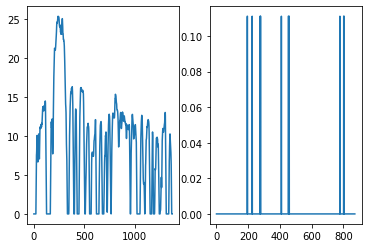

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 51.434
Episode: 57 Exploration P: 0.3654 Total reward: -2339.194404638111 SOC: 0.9538 Cumulative_SOC_deviation: 229.3786 Fuel Consumption: 45.4082

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



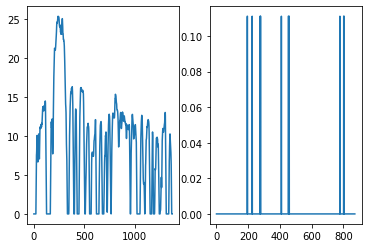

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.517
Episode: 58 Exploration P: 0.3584 Total reward: -2436.3576505694045 SOC: 0.9958 Cumulative_SOC_deviation: 233.2154 Fuel Consumption: 104.2037

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



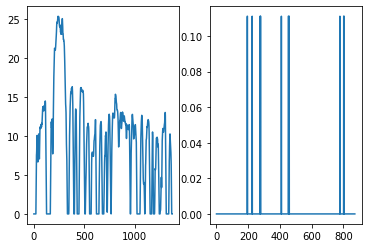

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.837
Episode: 59 Exploration P: 0.3515 Total reward: -2538.9558256816754 SOC: 1.0000 Cumulative_SOC_deviation: 246.7192 Fuel Consumption: 71.7643

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



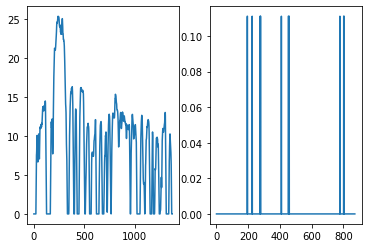

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.418
Episode: 60 Exploration P: 0.3447 Total reward: -2642.659301133897 SOC: 1.0000 Cumulative_SOC_deviation: 255.7124 Fuel Consumption: 85.5353

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



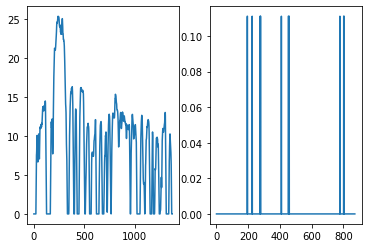

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.092
Episode: 61 Exploration P: 0.3380 Total reward: -1784.0570813343327 SOC: 0.8821 Cumulative_SOC_deviation: 172.4430 Fuel Consumption: 59.6273

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.5229842619497 SOC: -0.0008 Cumulative_SOC_deviation: 301.9224 Fuel Consumption: 1.3074
******************* Test is done *****************



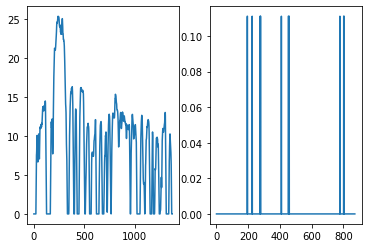

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.088
Episode: 62 Exploration P: 0.3315 Total reward: -2236.89598679357 SOC: 1.0000 Cumulative_SOC_deviation: 219.1415 Fuel Consumption: 45.4808

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



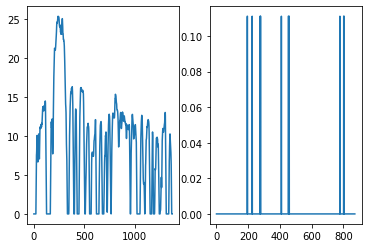

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.831
Episode: 63 Exploration P: 0.3252 Total reward: -2228.5713120969285 SOC: 0.9875 Cumulative_SOC_deviation: 218.3163 Fuel Consumption: 45.4082

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



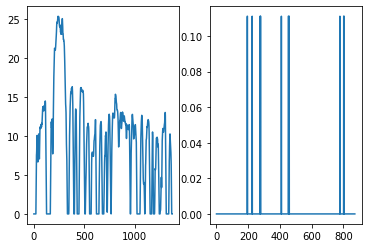

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.764
Episode: 64 Exploration P: 0.3189 Total reward: -2230.253724107672 SOC: 0.9883 Cumulative_SOC_deviation: 218.7827 Fuel Consumption: 42.4262

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



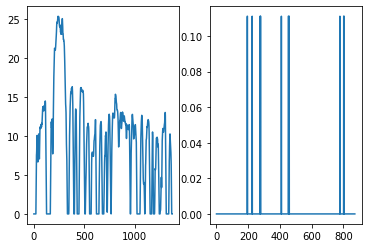

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.651
Episode: 65 Exploration P: 0.3128 Total reward: -2104.557068133503 SOC: 0.9359 Cumulative_SOC_deviation: 205.8427 Fuel Consumption: 46.1304

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



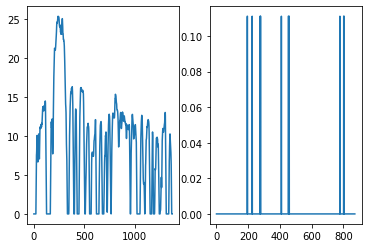

maximum steps, simulation is done ... 
elapsed_time: 44.425
Episode: 66 Exploration P: 0.3068 Total reward: -2263.8978513707175 SOC: 0.9957 Cumulative_SOC_deviation: 222.3711 Fuel Consumption: 40.1872

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



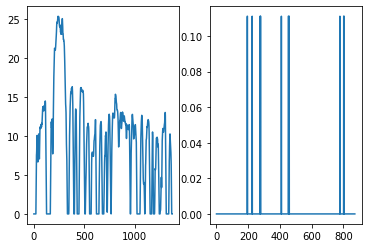

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.898
Episode: 67 Exploration P: 0.3009 Total reward: -1791.4119302050424 SOC: 0.9317 Cumulative_SOC_deviation: 174.7933 Fuel Consumption: 43.4787

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



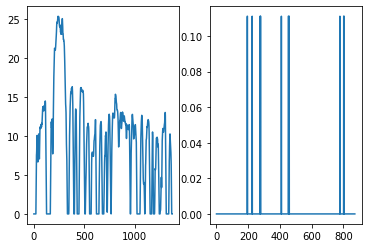

maximum steps, simulation is done ... 
elapsed_time: 44.576
Episode: 68 Exploration P: 0.2952 Total reward: -2141.9282906283756 SOC: 0.9862 Cumulative_SOC_deviation: 210.2670 Fuel Consumption: 39.2586

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



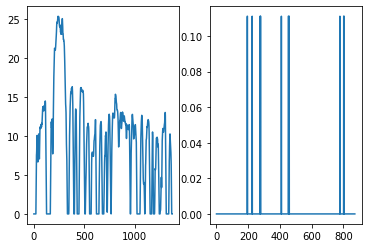

maximum steps, simulation is done ... 
elapsed_time: 44.542
Episode: 69 Exploration P: 0.2895 Total reward: -2180.3378620372764 SOC: 0.9964 Cumulative_SOC_deviation: 214.3164 Fuel Consumption: 37.1743

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



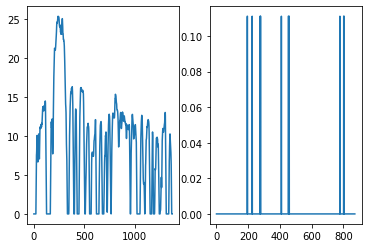

maximum steps, simulation is done ... 
elapsed_time: 44.233
Episode: 70 Exploration P: 0.2840 Total reward: -2263.782883457694 SOC: 0.9971 Cumulative_SOC_deviation: 222.4380 Fuel Consumption: 39.4030

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



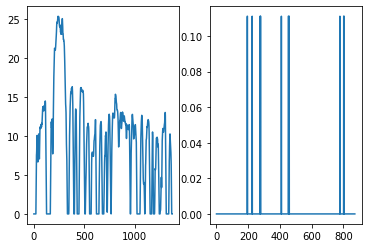

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.153
Episode: 71 Exploration P: 0.2785 Total reward: -1333.2449381605309 SOC: 0.8783 Cumulative_SOC_deviation: 128.8466 Fuel Consumption: 44.7788

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



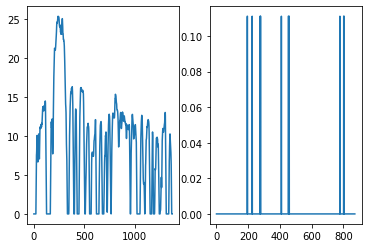

maximum steps, simulation is done ... 
elapsed_time: 44.940
Episode: 72 Exploration P: 0.2732 Total reward: -1944.7554802862885 SOC: 0.9346 Cumulative_SOC_deviation: 190.8076 Fuel Consumption: 36.6790

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



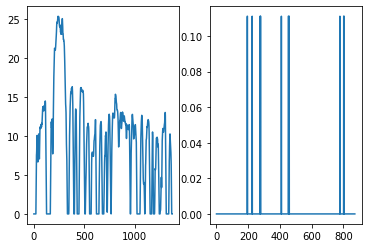

maximum steps, simulation is done ... 
elapsed_time: 44.261
Episode: 73 Exploration P: 0.2680 Total reward: -1466.990885245214 SOC: 0.8883 Cumulative_SOC_deviation: 143.0993 Fuel Consumption: 35.9980

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



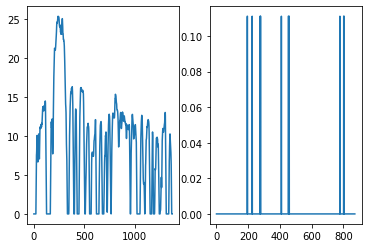

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.567
Episode: 74 Exploration P: 0.2629 Total reward: -1615.7321189250558 SOC: 0.8954 Cumulative_SOC_deviation: 157.5772 Fuel Consumption: 39.9602

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



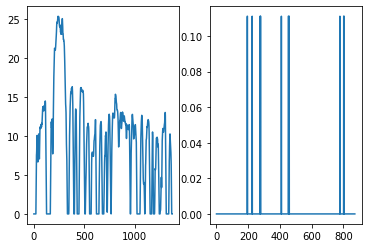

maximum steps, simulation is done ... 
elapsed_time: 45.165
Episode: 75 Exploration P: 0.2579 Total reward: -1867.4827617036046 SOC: 0.9450 Cumulative_SOC_deviation: 183.3115 Fuel Consumption: 34.3678

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



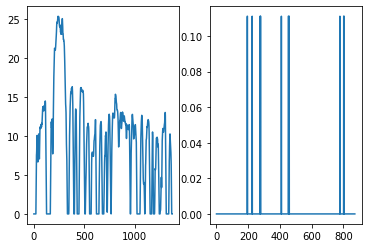

maximum steps, simulation is done ... 
elapsed_time: 51.066
Episode: 76 Exploration P: 0.2530 Total reward: -1473.222784668294 SOC: 0.8652 Cumulative_SOC_deviation: 143.8907 Fuel Consumption: 34.3162

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



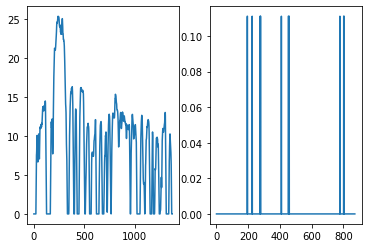

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.071
Episode: 77 Exploration P: 0.2481 Total reward: -1622.967820329902 SOC: 0.9077 Cumulative_SOC_deviation: 158.2347 Fuel Consumption: 40.6206

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



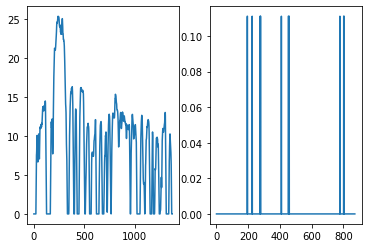

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.459
Episode: 78 Exploration P: 0.2434 Total reward: -1407.2529138572406 SOC: 0.8812 Cumulative_SOC_deviation: 136.9119 Fuel Consumption: 38.1339

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



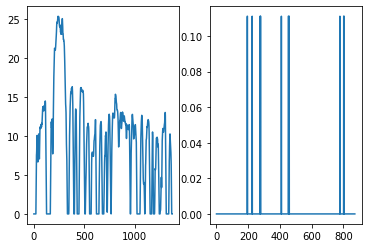

maximum steps, simulation is done ... 
elapsed_time: 45.299
Episode: 79 Exploration P: 0.2388 Total reward: -1854.7486620249117 SOC: 0.9277 Cumulative_SOC_deviation: 182.0474 Fuel Consumption: 34.2749

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



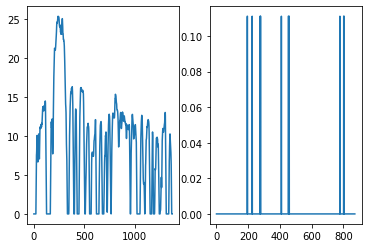

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.096
Episode: 80 Exploration P: 0.2343 Total reward: -1265.434686763583 SOC: 0.7719 Cumulative_SOC_deviation: 122.6971 Fuel Consumption: 38.4641

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



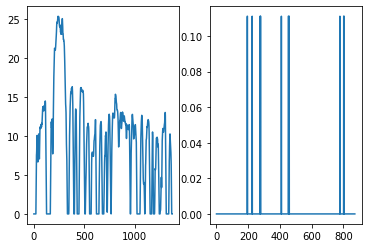

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.162
Episode: 81 Exploration P: 0.2298 Total reward: -1551.88322373443 SOC: 0.7893 Cumulative_SOC_deviation: 151.6164 Fuel Consumption: 35.7194

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



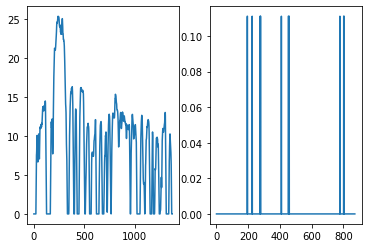

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.781
Episode: 82 Exploration P: 0.2255 Total reward: -1587.7059579680883 SOC: 0.8921 Cumulative_SOC_deviation: 155.2100 Fuel Consumption: 35.6059

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



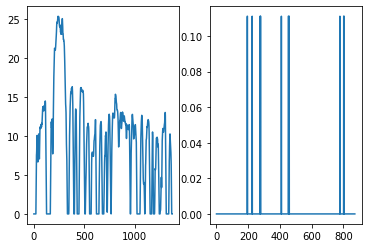

maximum steps, simulation is done ... 
elapsed_time: 44.689
Episode: 83 Exploration P: 0.2212 Total reward: -1668.8816250936077 SOC: 0.8922 Cumulative_SOC_deviation: 163.7847 Fuel Consumption: 31.0350

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



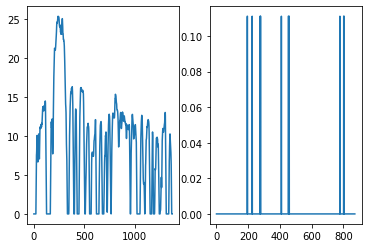

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.454
Episode: 84 Exploration P: 0.2170 Total reward: -1144.6492465596423 SOC: 0.8050 Cumulative_SOC_deviation: 110.8032 Fuel Consumption: 36.6171

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



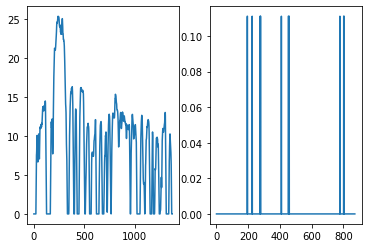

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.430
Episode: 85 Exploration P: 0.2129 Total reward: -1536.4319684713128 SOC: 0.8902 Cumulative_SOC_deviation: 150.3137 Fuel Consumption: 33.2947

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



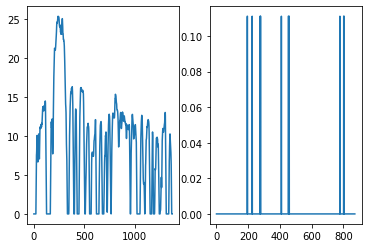

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.995
Episode: 86 Exploration P: 0.2089 Total reward: -1116.1276017088574 SOC: 0.8219 Cumulative_SOC_deviation: 108.6310 Fuel Consumption: 29.8175

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



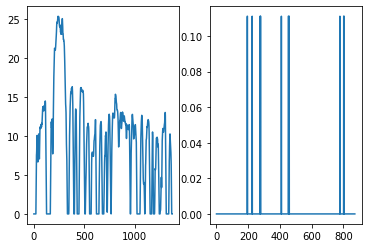

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.893
Episode: 87 Exploration P: 0.2049 Total reward: -1207.1122347762182 SOC: 0.7994 Cumulative_SOC_deviation: 117.1548 Fuel Consumption: 35.5647

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



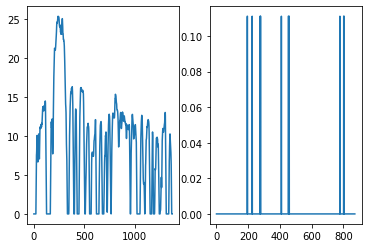

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.525
Episode: 88 Exploration P: 0.2011 Total reward: -812.9144040731576 SOC: 0.7701 Cumulative_SOC_deviation: 78.4768 Fuel Consumption: 28.1459

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



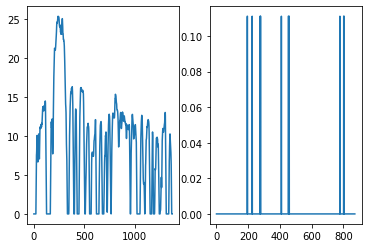

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.842
Episode: 89 Exploration P: 0.1973 Total reward: -930.6549091606825 SOC: 0.7604 Cumulative_SOC_deviation: 89.9558 Fuel Consumption: 31.0969

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



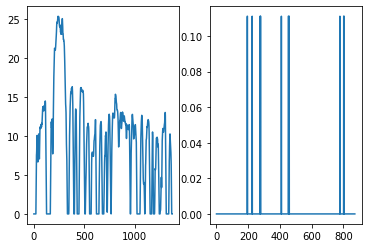

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.210
Episode: 90 Exploration P: 0.1936 Total reward: -1396.6090713888002 SOC: 0.8681 Cumulative_SOC_deviation: 136.2644 Fuel Consumption: 33.9654

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



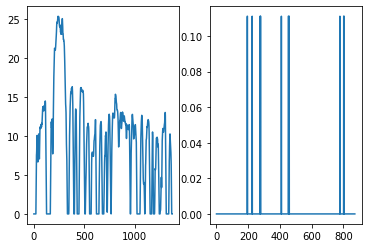

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.001
Episode: 91 Exploration P: 0.1899 Total reward: -1075.3714759536508 SOC: 0.7946 Cumulative_SOC_deviation: 104.4099 Fuel Consumption: 31.2723

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



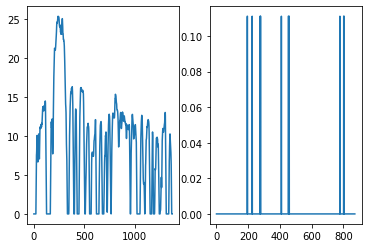

maximum steps, simulation is done ... 
elapsed_time: 43.882
Episode: 92 Exploration P: 0.1864 Total reward: -1136.8335243003758 SOC: 0.7833 Cumulative_SOC_deviation: 111.0627 Fuel Consumption: 26.2061

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



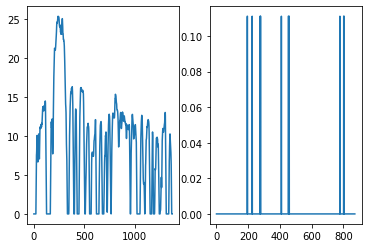

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.648
Episode: 93 Exploration P: 0.1829 Total reward: -1081.5210182671979 SOC: 0.7821 Cumulative_SOC_deviation: 105.1848 Fuel Consumption: 29.6730

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



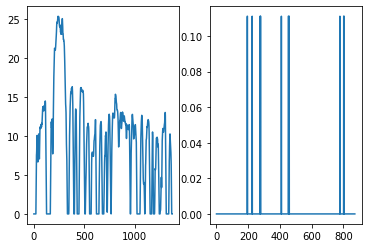

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.357
Episode: 94 Exploration P: 0.1794 Total reward: -1147.3510321833605 SOC: 0.8150 Cumulative_SOC_deviation: 111.8101 Fuel Consumption: 29.2500

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



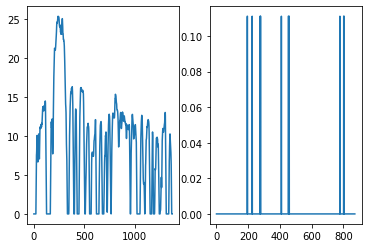

maximum steps, simulation is done ... 
elapsed_time: 44.910
Episode: 95 Exploration P: 0.1761 Total reward: -1134.6334484139827 SOC: 0.8006 Cumulative_SOC_deviation: 110.6807 Fuel Consumption: 27.8261

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



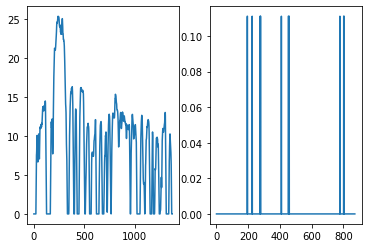

maximum steps, simulation is done ... 
elapsed_time: 44.137
Episode: 96 Exploration P: 0.1728 Total reward: -1114.8777105747724 SOC: 0.8300 Cumulative_SOC_deviation: 108.6918 Fuel Consumption: 27.9602

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



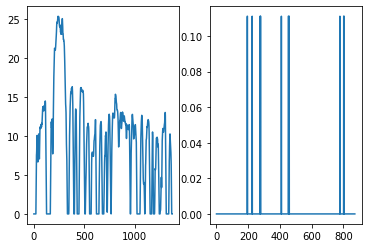

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.225
Episode: 97 Exploration P: 0.1696 Total reward: -731.5587205486838 SOC: 0.7013 Cumulative_SOC_deviation: 70.2278 Fuel Consumption: 29.2809

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



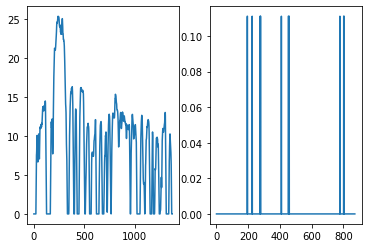

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.857
Episode: 98 Exploration P: 0.1664 Total reward: -857.8605004269176 SOC: 0.7650 Cumulative_SOC_deviation: 83.1469 Fuel Consumption: 26.3918

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



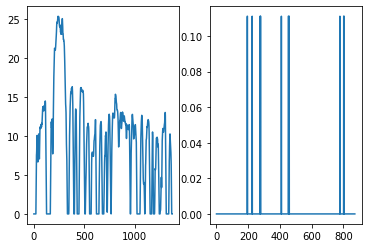

maximum steps, simulation is done ... 
elapsed_time: 44.493
Episode: 99 Exploration P: 0.1633 Total reward: -929.2336731067002 SOC: 0.7632 Cumulative_SOC_deviation: 90.6948 Fuel Consumption: 22.2852

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



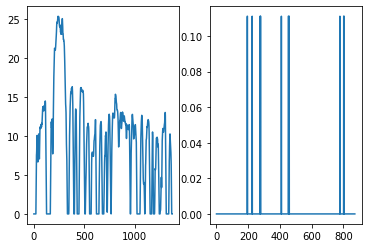

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.462
Episode: 100 Exploration P: 0.1603 Total reward: -888.3216762902498 SOC: 0.7752 Cumulative_SOC_deviation: 85.9330 Fuel Consumption: 28.9920

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



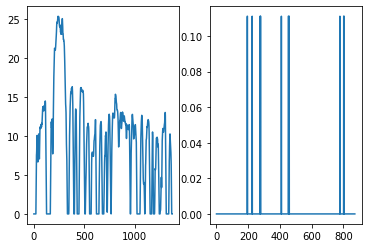

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.260
Episode: 101 Exploration P: 0.1573 Total reward: -1257.7146061113742 SOC: 0.5305 Cumulative_SOC_deviation: 122.2356 Fuel Consumption: 35.3583

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



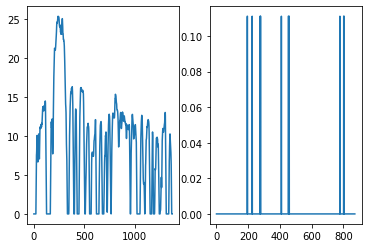

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.314
Episode: 102 Exploration P: 0.1544 Total reward: -495.8919711860339 SOC: 0.6930 Cumulative_SOC_deviation: 46.8355 Fuel Consumption: 27.5372

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



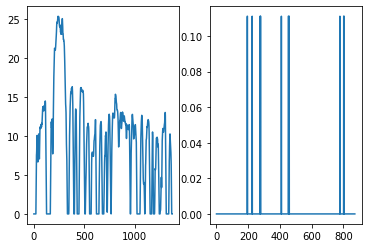

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.853
Episode: 103 Exploration P: 0.1515 Total reward: -912.0997457315119 SOC: 0.5635 Cumulative_SOC_deviation: 88.3221 Fuel Consumption: 28.8785

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



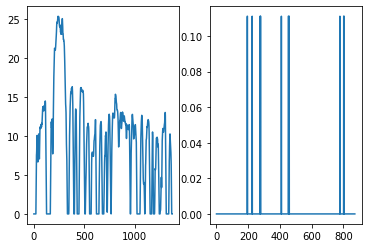

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.364
Episode: 104 Exploration P: 0.1487 Total reward: -182.1128220700332 SOC: 0.6365 Cumulative_SOC_deviation: 15.6577 Fuel Consumption: 25.5354

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



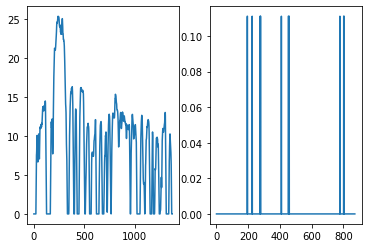

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.579
Episode: 105 Exploration P: 0.1459 Total reward: -523.5084331476553 SOC: 0.7076 Cumulative_SOC_deviation: 49.9438 Fuel Consumption: 24.0703

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



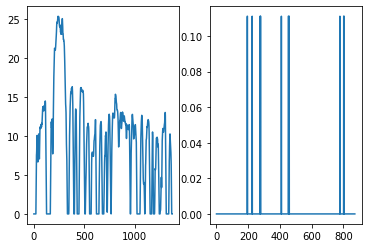

maximum steps, simulation is done ... 
elapsed_time: 44.544
Episode: 106 Exploration P: 0.1433 Total reward: -691.5101162186119 SOC: 0.7292 Cumulative_SOC_deviation: 67.0484 Fuel Consumption: 21.0264

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



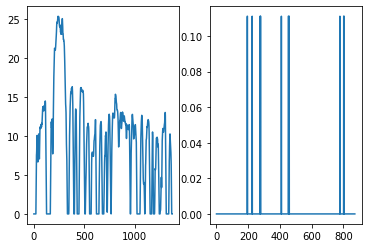

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.295
Episode: 107 Exploration P: 0.1406 Total reward: -360.4584910569311 SOC: 0.6633 Cumulative_SOC_deviation: 33.9886 Fuel Consumption: 20.5724

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



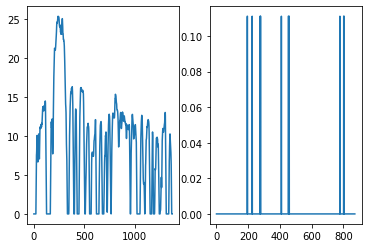

maximum steps, simulation is done ... 
elapsed_time: 44.018
Episode: 108 Exploration P: 0.1380 Total reward: -366.82925824865197 SOC: 0.6541 Cumulative_SOC_deviation: 34.5617 Fuel Consumption: 21.2121

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



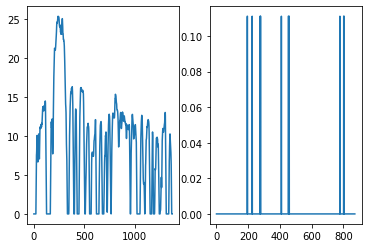

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.525
Episode: 109 Exploration P: 0.1355 Total reward: -278.47344734021516 SOC: 0.6842 Cumulative_SOC_deviation: 25.7096 Fuel Consumption: 21.3772

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



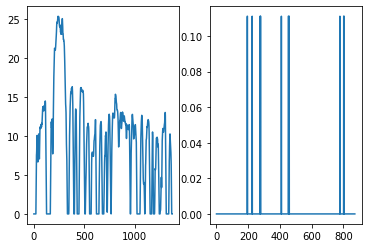

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.435
Episode: 110 Exploration P: 0.1330 Total reward: -187.66389496082863 SOC: 0.5746 Cumulative_SOC_deviation: 16.5740 Fuel Consumption: 21.9241

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



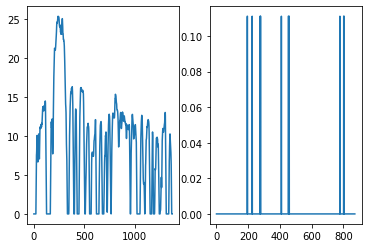

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 126492.31501603345(+) but condition is not avail
elapsed_time: 26.130
Episode: 111 Exploration P: 0.1316 Total reward: -1122.783479184959 SOC: 0.4344 Cumulative_SOC_deviation: 10.6440 Fuel Consumption: 17.9997

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



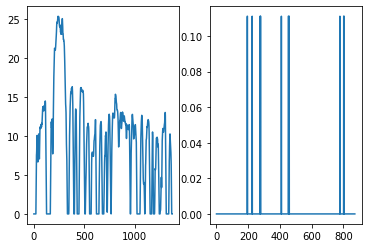

maximum steps, simulation is done ... 
elapsed_time: 45.630
Episode: 112 Exploration P: 0.1292 Total reward: -570.0280270074044 SOC: 0.6918 Cumulative_SOC_deviation: 55.1168 Fuel Consumption: 18.8596

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



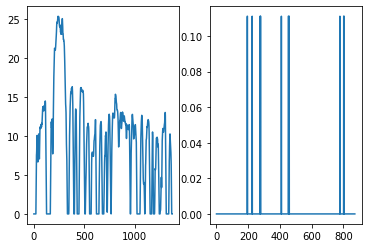

maximum steps, simulation is done ... 
elapsed_time: 44.927
Episode: 113 Exploration P: 0.1268 Total reward: -747.4779348341814 SOC: 0.7570 Cumulative_SOC_deviation: 72.7679 Fuel Consumption: 19.7986

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



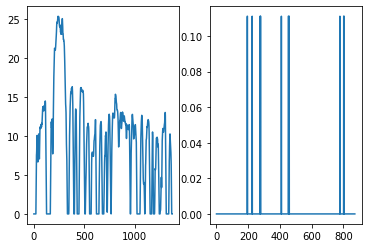

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.144
Episode: 114 Exploration P: 0.1245 Total reward: -397.1211974875679 SOC: 0.6813 Cumulative_SOC_deviation: 37.8901 Fuel Consumption: 18.2199

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



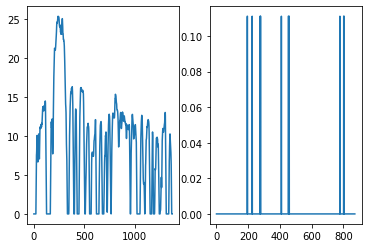

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.156
Episode: 115 Exploration P: 0.1222 Total reward: -150.75174946730655 SOC: 0.5768 Cumulative_SOC_deviation: 13.3182 Fuel Consumption: 17.5698

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



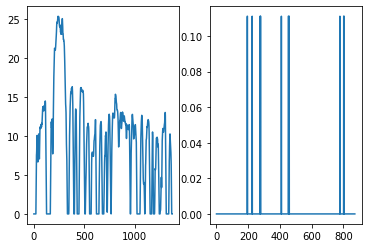

maximum steps, simulation is done ... 
elapsed_time: 45.520
Episode: 116 Exploration P: 0.1200 Total reward: -681.948530265707 SOC: 0.7405 Cumulative_SOC_deviation: 66.4018 Fuel Consumption: 17.9310

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



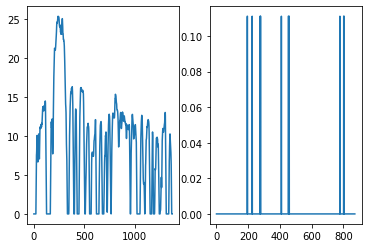

maximum steps, simulation is done ... 
elapsed_time: 44.511
Episode: 117 Exploration P: 0.1178 Total reward: -472.42964919570454 SOC: 0.6936 Cumulative_SOC_deviation: 45.4395 Fuel Consumption: 18.0342

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



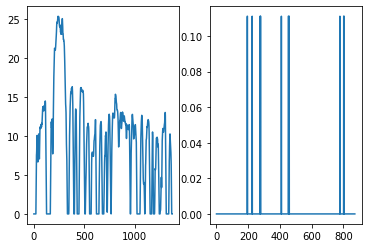

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 53.428
Episode: 118 Exploration P: 0.1157 Total reward: -254.79981451498665 SOC: 0.6189 Cumulative_SOC_deviation: 23.6260 Fuel Consumption: 18.5397

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



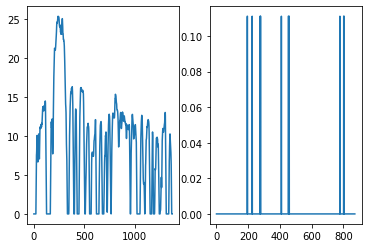

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.888
Episode: 119 Exploration P: 0.1136 Total reward: -650.7149105392663 SOC: 0.7211 Cumulative_SOC_deviation: 63.0349 Fuel Consumption: 20.3661

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



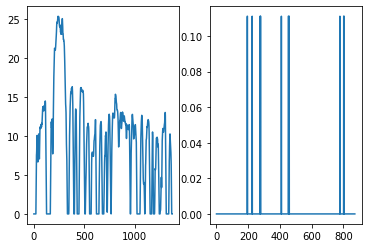

maximum steps, simulation is done ... 
elapsed_time: 44.454
Episode: 120 Exploration P: 0.1115 Total reward: -606.1539172269299 SOC: 0.7191 Cumulative_SOC_deviation: 58.9894 Fuel Consumption: 16.2594

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



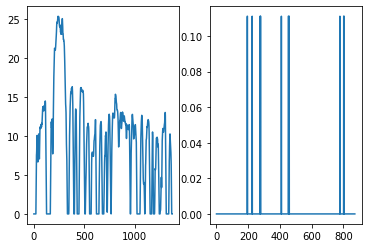

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.070
Episode: 121 Exploration P: 0.1095 Total reward: -351.2859921628767 SOC: 0.6715 Cumulative_SOC_deviation: 33.4026 Fuel Consumption: 17.2603

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



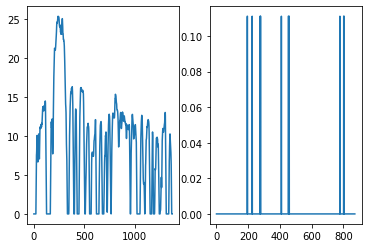

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.817
Episode: 122 Exploration P: 0.1075 Total reward: -354.76187023135753 SOC: 0.5717 Cumulative_SOC_deviation: 33.2064 Fuel Consumption: 22.6980

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



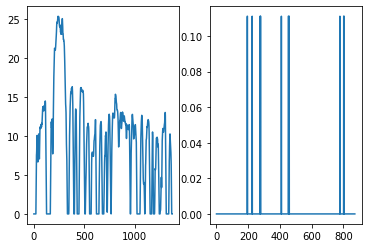

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.555
Episode: 123 Exploration P: 0.1056 Total reward: -377.59378044300195 SOC: 0.5446 Cumulative_SOC_deviation: 36.0973 Fuel Consumption: 16.6206

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



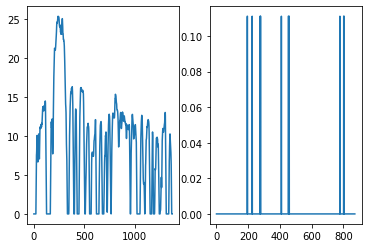

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.361
Episode: 124 Exploration P: 0.1037 Total reward: -109.83891382189866 SOC: 0.5916 Cumulative_SOC_deviation: 9.8336 Fuel Consumption: 11.5028

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



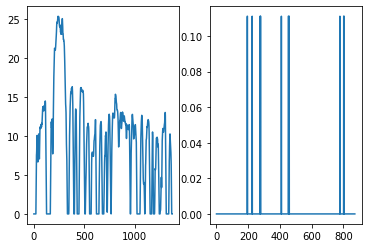

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.142
Episode: 125 Exploration P: 0.1019 Total reward: -709.7637951987539 SOC: 0.4570 Cumulative_SOC_deviation: 69.3401 Fuel Consumption: 16.3626

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



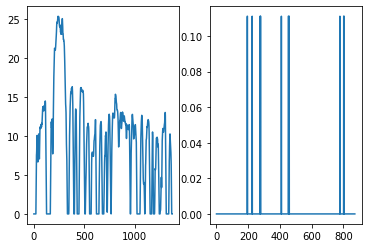

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.667
Episode: 126 Exploration P: 0.1000 Total reward: -459.77185571089217 SOC: 0.6610 Cumulative_SOC_deviation: 44.2553 Fuel Consumption: 17.2190

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



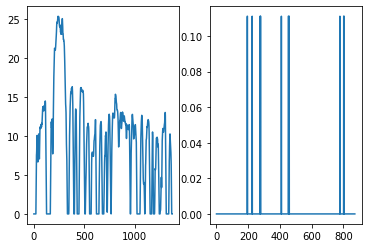

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.336
Episode: 127 Exploration P: 0.0983 Total reward: -406.43123035902363 SOC: 0.5167 Cumulative_SOC_deviation: 38.9573 Fuel Consumption: 16.8579

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



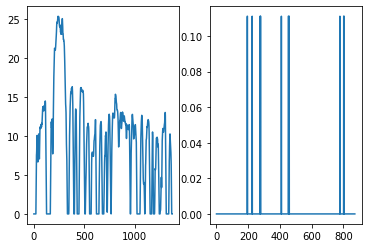

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 44.278
Episode: 128 Exploration P: 0.0965 Total reward: -132.50870302038757 SOC: 0.6013 Cumulative_SOC_deviation: 11.8395 Fuel Consumption: 14.1133

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



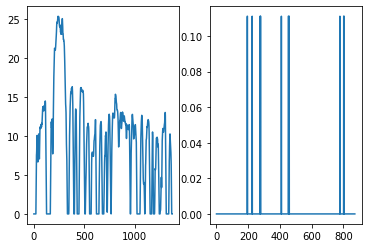

maximum steps, simulation is done ... 
elapsed_time: 44.143
Episode: 129 Exploration P: 0.0948 Total reward: -274.13712385768343 SOC: 0.6345 Cumulative_SOC_deviation: 26.1056 Fuel Consumption: 13.0814

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



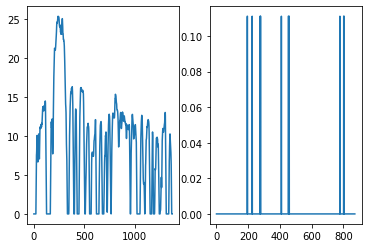

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.082
Episode: 130 Exploration P: 0.0931 Total reward: -842.2775735555898 SOC: 0.3190 Cumulative_SOC_deviation: 82.0436 Fuel Consumption: 21.8415

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



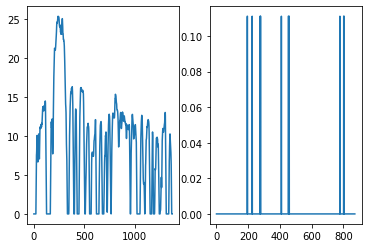

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.729
Episode: 131 Exploration P: 0.0915 Total reward: -647.2969927755145 SOC: 0.4751 Cumulative_SOC_deviation: 63.2482 Fuel Consumption: 14.8149

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



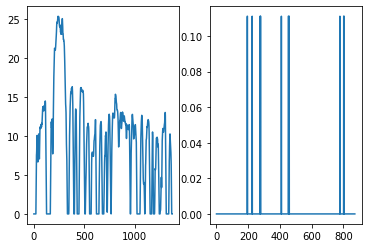

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.392
Episode: 132 Exploration P: 0.0898 Total reward: -687.2508225085545 SOC: 0.4746 Cumulative_SOC_deviation: 67.0661 Fuel Consumption: 16.5896

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



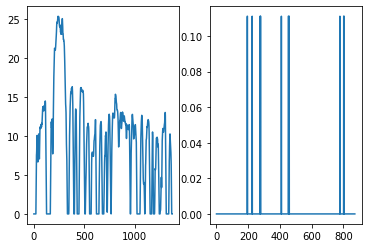

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 71543.94983815178(+) but condition is not avail
elapsed_time: 6.596
Episode: 133 Exploration P: 0.0896 Total reward: -1038.01469929149 SOC: 0.5137 Cumulative_SOC_deviation: 3.2118 Fuel Consumption: 7.3168

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



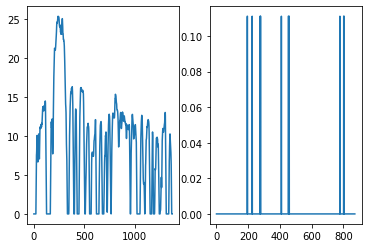

maximum steps, simulation is done ... 
elapsed_time: 45.627
Episode: 134 Exploration P: 0.0880 Total reward: -157.3569897282295 SOC: 0.6273 Cumulative_SOC_deviation: 14.6257 Fuel Consumption: 11.1004

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



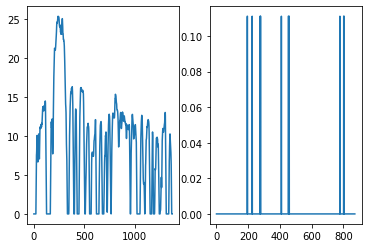

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.923
Episode: 135 Exploration P: 0.0865 Total reward: -419.679876806296 SOC: 0.5484 Cumulative_SOC_deviation: 40.6010 Fuel Consumption: 13.6696

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



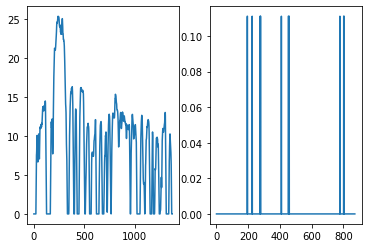

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.581
Episode: 136 Exploration P: 0.0850 Total reward: -116.05694023364399 SOC: 0.6081 Cumulative_SOC_deviation: 10.4265 Fuel Consumption: 11.7917

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



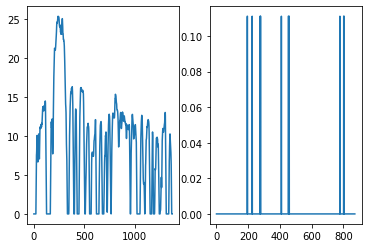

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.027
Episode: 137 Exploration P: 0.0835 Total reward: -227.17475442463228 SOC: 0.5125 Cumulative_SOC_deviation: 21.2153 Fuel Consumption: 15.0213

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



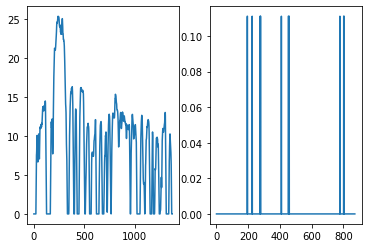

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 93398.30504718951(+) but condition is not avail
elapsed_time: 42.310
Episode: 138 Exploration P: 0.0821 Total reward: -1838.078987782732 SOC: 0.2486 Cumulative_SOC_deviation: 81.2684 Fuel Consumption: 29.2803

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



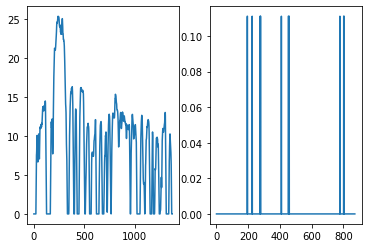

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.484
Episode: 139 Exploration P: 0.0807 Total reward: -132.22588893789984 SOC: 0.5206 Cumulative_SOC_deviation: 12.0568 Fuel Consumption: 11.6575

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



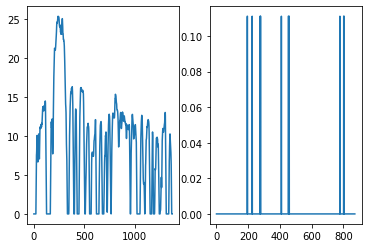

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 48.692
Episode: 140 Exploration P: 0.0793 Total reward: -542.3891566356134 SOC: 0.5252 Cumulative_SOC_deviation: 52.1177 Fuel Consumption: 21.2121

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



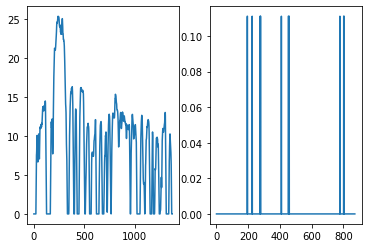

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 52.414
Episode: 141 Exploration P: 0.0779 Total reward: -144.40423909009434 SOC: 0.5827 Cumulative_SOC_deviation: 13.0116 Fuel Consumption: 14.2887

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



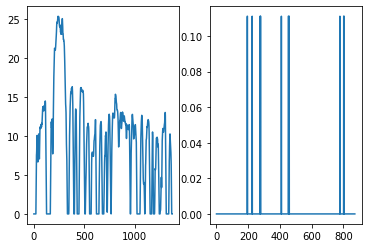

maximum steps, simulation is done ... 
elapsed_time: 46.435
Episode: 142 Exploration P: 0.0766 Total reward: -197.12415365418033 SOC: 0.5663 Cumulative_SOC_deviation: 18.4559 Fuel Consumption: 12.5655

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



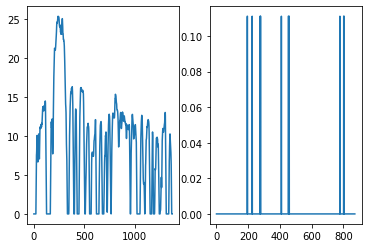

maximum steps, simulation is done ... 
elapsed_time: 44.766
Episode: 143 Exploration P: 0.0753 Total reward: -117.51862599547385 SOC: 0.5769 Cumulative_SOC_deviation: 10.8699 Fuel Consumption: 8.8201

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



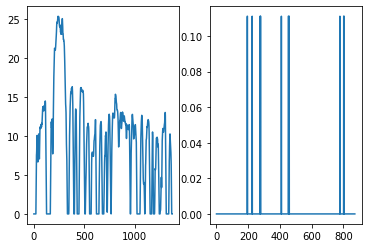

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.251
Episode: 144 Exploration P: 0.0740 Total reward: -77.52976657141087 SOC: 0.5823 Cumulative_SOC_deviation: 6.7379 Fuel Consumption: 10.1511

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



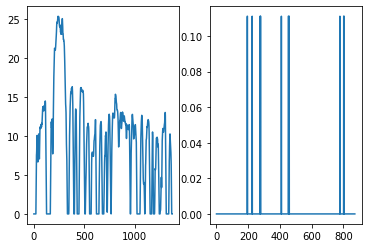

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.733
Episode: 145 Exploration P: 0.0727 Total reward: -535.0307136783609 SOC: 0.5152 Cumulative_SOC_deviation: 51.8658 Fuel Consumption: 16.3729

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



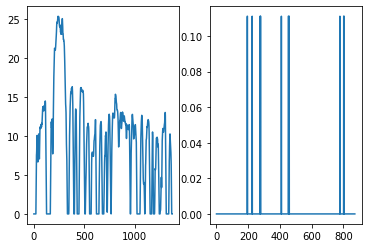

maximum steps, simulation is done ... 
elapsed_time: 43.827
Episode: 146 Exploration P: 0.0715 Total reward: -258.3827776173587 SOC: 0.5760 Cumulative_SOC_deviation: 24.9852 Fuel Consumption: 8.5311

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



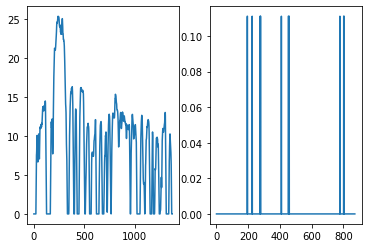

maximum steps, simulation is done ... 
elapsed_time: 43.653
Episode: 147 Exploration P: 0.0702 Total reward: -71.14237425374537 SOC: 0.6048 Cumulative_SOC_deviation: 6.1559 Fuel Consumption: 9.5836

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



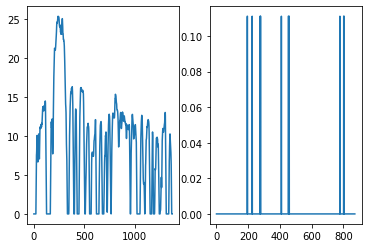

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.776
Episode: 148 Exploration P: 0.0691 Total reward: -439.12685893653344 SOC: 0.5538 Cumulative_SOC_deviation: 42.7397 Fuel Consumption: 11.7298

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



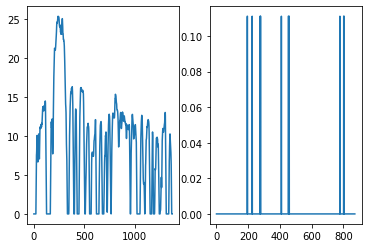

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.436
Episode: 149 Exploration P: 0.0679 Total reward: -722.3858007072542 SOC: 0.5153 Cumulative_SOC_deviation: 71.2348 Fuel Consumption: 10.0376

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



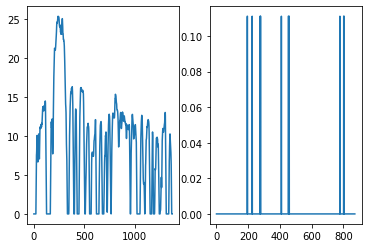

maximum steps, simulation is done ... 
elapsed_time: 44.058
Episode: 150 Exploration P: 0.0667 Total reward: -189.2768761989676 SOC: 0.5634 Cumulative_SOC_deviation: 18.1055 Fuel Consumption: 8.2216

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



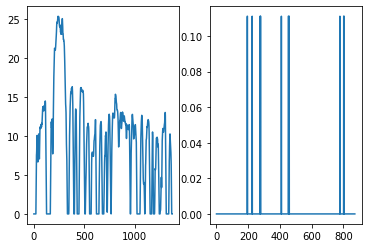

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.808
Episode: 151 Exploration P: 0.0656 Total reward: -567.4033240903632 SOC: 0.4713 Cumulative_SOC_deviation: 55.3981 Fuel Consumption: 13.4219

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



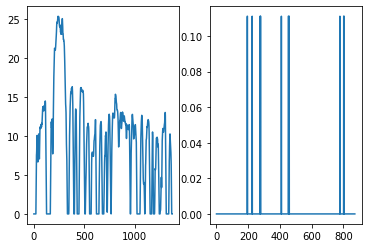

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.749
Episode: 152 Exploration P: 0.0645 Total reward: -627.7295017177147 SOC: 0.4915 Cumulative_SOC_deviation: 61.6650 Fuel Consumption: 11.0797

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



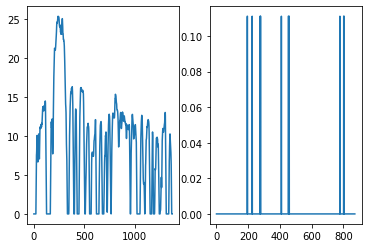

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.740
Episode: 153 Exploration P: 0.0634 Total reward: -757.0631454348597 SOC: 0.4675 Cumulative_SOC_deviation: 74.6128 Fuel Consumption: 10.9353

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



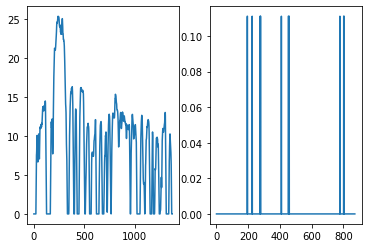

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.789
Episode: 154 Exploration P: 0.0624 Total reward: -591.4593755739055 SOC: 0.5200 Cumulative_SOC_deviation: 57.8512 Fuel Consumption: 12.9473

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



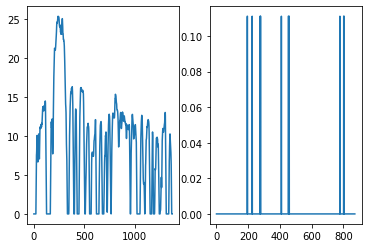

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.889
Episode: 155 Exploration P: 0.0613 Total reward: -104.19163765850682 SOC: 0.5811 Cumulative_SOC_deviation: 9.3153 Fuel Consumption: 11.0385

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



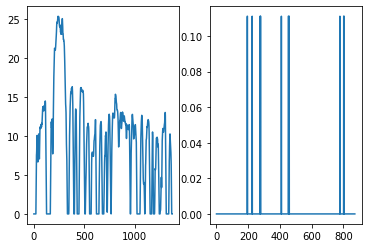

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 43.976
Episode: 156 Exploration P: 0.0603 Total reward: -200.5231605101027 SOC: 0.5427 Cumulative_SOC_deviation: 19.1600 Fuel Consumption: 8.9232

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



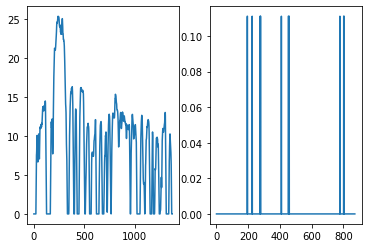

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.298
Episode: 157 Exploration P: 0.0593 Total reward: -216.47293235758306 SOC: 0.5660 Cumulative_SOC_deviation: 20.8055 Fuel Consumption: 8.4176

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



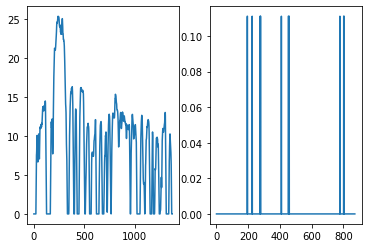

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 47.525
Episode: 158 Exploration P: 0.0583 Total reward: -151.75917610873972 SOC: 0.5508 Cumulative_SOC_deviation: 14.2908 Fuel Consumption: 8.8510

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



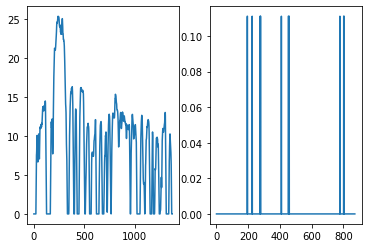

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.575
Episode: 159 Exploration P: 0.0574 Total reward: -703.1670201756525 SOC: 0.4511 Cumulative_SOC_deviation: 69.0302 Fuel Consumption: 12.8648

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



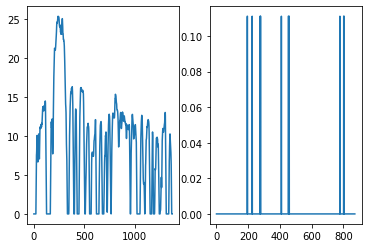

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.044
Episode: 160 Exploration P: 0.0564 Total reward: -349.75937106115634 SOC: 0.5372 Cumulative_SOC_deviation: 33.8742 Fuel Consumption: 11.0178

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



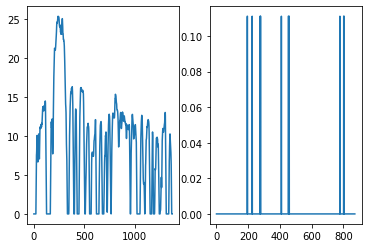

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.486
Episode: 161 Exploration P: 0.0555 Total reward: -340.8845573667394 SOC: 0.5479 Cumulative_SOC_deviation: 33.2085 Fuel Consumption: 8.7994

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



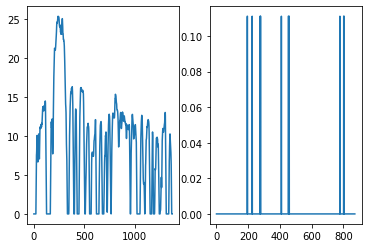

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 44.519
Episode: 162 Exploration P: 0.0546 Total reward: -151.24619545734922 SOC: 0.5424 Cumulative_SOC_deviation: 14.1394 Fuel Consumption: 9.8519

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



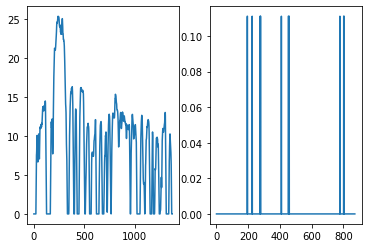

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 46.188
Episode: 163 Exploration P: 0.0537 Total reward: -258.3977241453618 SOC: 0.5392 Cumulative_SOC_deviation: 24.9175 Fuel Consumption: 9.2225

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



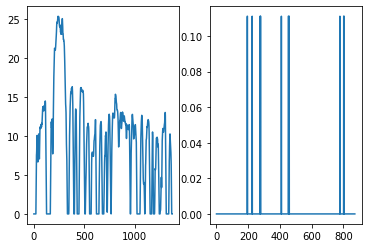

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 109796.77763939621(+) but condition is not avail
elapsed_time: 28.474
Episode: 164 Exploration P: 0.0532 Total reward: -1157.2783901758382 SOC: 0.4782 Cumulative_SOC_deviation: 15.0515 Fuel Consumption: 7.9812

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



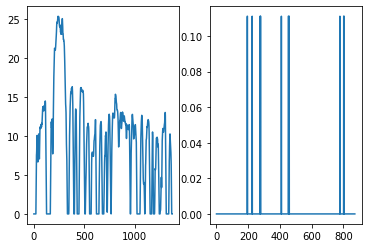

maximum steps, simulation is done ... 
elapsed_time: 44.210
Episode: 165 Exploration P: 0.0523 Total reward: -106.87334432723132 SOC: 0.5752 Cumulative_SOC_deviation: 9.7114 Fuel Consumption: 9.7590

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



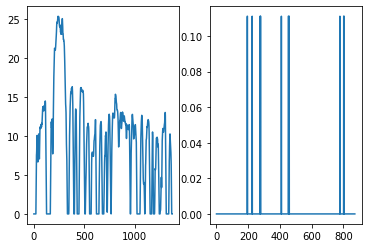

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.775
Episode: 166 Exploration P: 0.0515 Total reward: -438.21528711648943 SOC: 0.5121 Cumulative_SOC_deviation: 43.0293 Fuel Consumption: 7.9224

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



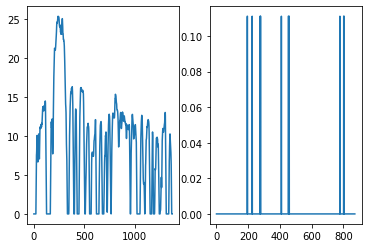

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.927
Episode: 167 Exploration P: 0.0507 Total reward: -512.1986476605608 SOC: 0.5266 Cumulative_SOC_deviation: 50.3420 Fuel Consumption: 8.7788

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



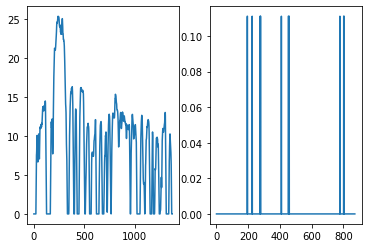

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.347
Episode: 168 Exploration P: 0.0499 Total reward: -204.64975708262918 SOC: 0.5375 Cumulative_SOC_deviation: 19.6046 Fuel Consumption: 8.6034

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



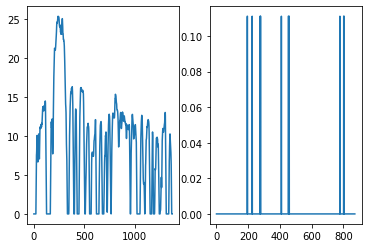

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 105863.08319195102(+) but condition is not avail
elapsed_time: 33.354
Episode: 169 Exploration P: 0.0493 Total reward: -1188.656993231175 SOC: 0.3737 Cumulative_SOC_deviation: 17.9481 Fuel Consumption: 11.4388

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



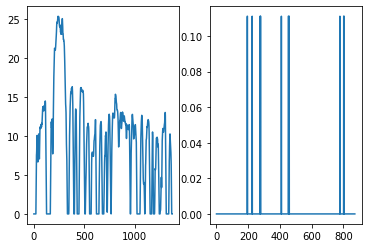

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.879
Episode: 170 Exploration P: 0.0485 Total reward: -629.7528790374575 SOC: 0.4358 Cumulative_SOC_deviation: 62.1861 Fuel Consumption: 7.8914

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



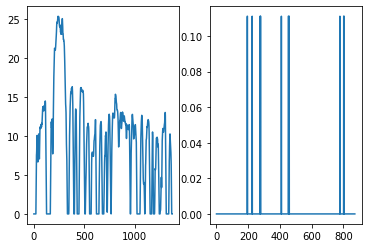

maximum steps, simulation is done ... 
elapsed_time: 45.221
Episode: 171 Exploration P: 0.0477 Total reward: -328.55374160248005 SOC: 0.5461 Cumulative_SOC_deviation: 32.4222 Fuel Consumption: 4.3317

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



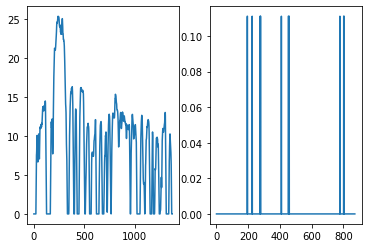

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.045
Episode: 172 Exploration P: 0.0470 Total reward: -779.3651398733972 SOC: 0.4650 Cumulative_SOC_deviation: 77.2392 Fuel Consumption: 6.9731

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



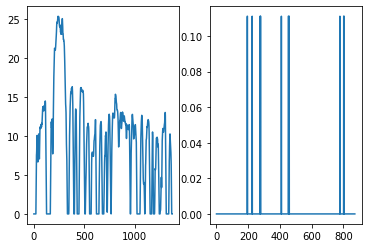

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.754
Episode: 173 Exploration P: 0.0462 Total reward: -666.3070773699516 SOC: 0.4606 Cumulative_SOC_deviation: 65.4567 Fuel Consumption: 11.7401

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



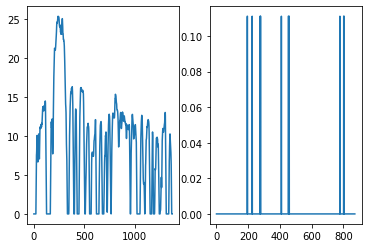

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.310
Episode: 174 Exploration P: 0.0455 Total reward: -882.9881358190563 SOC: 0.4418 Cumulative_SOC_deviation: 87.3116 Fuel Consumption: 9.8725

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



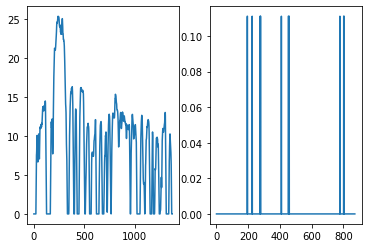

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.614
Episode: 175 Exploration P: 0.0448 Total reward: -2204.482775119604 SOC: 0.2641 Cumulative_SOC_deviation: 218.7439 Fuel Consumption: 17.0436

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



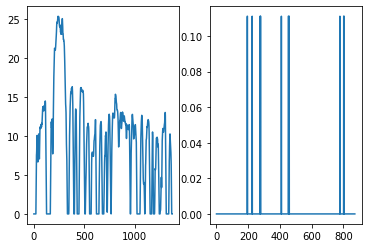

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 44.423
Episode: 176 Exploration P: 0.0441 Total reward: -751.8061915139181 SOC: 0.4162 Cumulative_SOC_deviation: 74.2470 Fuel Consumption: 9.3360

battery power is 5751.723564948133(+) but condition is not avail
******************* Test is start *****************
../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat
Total reward: -4014.524980132764 SOC: -0.0008 Cumulative_SOC_deviation: 301.9226 Fuel Consumption: 1.3074
******************* Test is done *****************



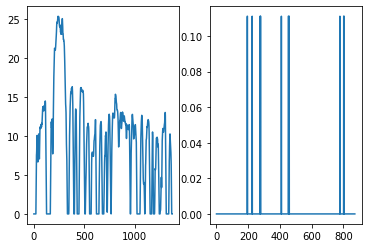

In [ ]:
# print(env.version)

num_trials = 1
results_dict = {} 
# driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 1 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
            
    root = "DDPG_MDP_mass1200_ver2"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
            
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [ ]:
with open("DDPG_MDP_mass1200_ver2.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# results_dict